In [2]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import concurrent.futures

import warnings
from typing import Self
from datetime import datetime
from functools import reduce
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from concurrent.futures import ThreadPoolExecutor, wait, FIRST_COMPLETED
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import src.utils.anomalydetectors as m
import src.utils.globals as g
import src.utils.aggregators as agg

from src.utils.experiment import Experiment
from src.utils.noise import NoiseFactory
from src.utils.plotting import plot_rpcurves

In [ ]:
def run_experiment(df : pd.DataFrame, models, columns, name, robotsids = []):
    df['anomalous'] = df['anomaly_syn_type'] != ""
    df_anomalies = df.groupby('seqid').agg({'anomalous' : any})

    experiment = Experiment(name)
    experiment.run(df, models, (['seqid', 'timeindex_bin'], columns), spliton="robotid", verbose=True)
    experiment.set_anomalies(df_anomalies)
    experiment.calculate_metrics(aggrfunc=agg.aggr_sqrtsum)

    experiment.pickle()

    return experiment


def name_experiment(prefix, ratio, intensity, robotids):
    name = f"{prefix}_{ratio}_{intensity}"

    if robotids:
        name = name + f"_{'_'.join(item.strip() for item in robotids)}"

    return name

def name_guassian_experiment(ratio, intensity, robotids):
    return name_experiment("gaussian", ratio, intensity, robotids)

def name_sinusoidal_experiment(ratio, intensity, robotids):
    return name_experiment("sinusoidal", ratio, intensity, robotids)

def name_point_experiment(ratio, intensity, robotids):
    return name_experiment("point", ratio, intensity, robotids)

def run_gaussian_experiment(df : pd.DataFrame, models, exp_columns, syn_column, ratio, intensity, robotids = []):
    name = name_guassian_experiment(ratio, intensity, robotids)

    if robotids:
        df = df[df['robotid'].isin(robotids)]

    df_syn = NoiseFactory.gaussian(df, syn_column, ratio, intensity)
    return run_experiment(df_syn, models, exp_columns, name)

def run_sinusoidal_experiment(df : pd.DataFrame, models, exp_columns, syn_column, ratio, intensity, robotids = []):
    name = name_sinusoidal_experiment(ratio, intensity, robotids)

    if robotids:
        df = df[df['robotid'].isin(robotids)]

    df_syn = NoiseFactory.sinusoidal(df, syn_column, ratio, intensity)
    return run_experiment(df_syn, models, exp_columns, name)

def run_point_experiment(df : pd.DataFrame, models, exp_columns, syn_column, ratio, intensity, robotids = []):
    name =  name_point_experiment(ratio, intensity, robotids)

    if robotids:
        df = df[df['robotid'].isin(robotids)]

    df_syn = NoiseFactory.point(df, syn_column, ratio, intensity)
    return run_experiment(df_syn, models, exp_columns, name)

In [4]:
df_in = pd.read_parquet(os.getcwd() + "/" + g.path_tracks)

In [5]:
# Boolean whether to run the experiments or load
load_experiments = True

# Running Experiment Parameters
models = [m.ZScore(), m.MZScore(), m.LOF(), m.IF()]
exp_columns = ['torqueactual']
syn_column = 'torqueactual'

guassian_params     = [0.10, 0.25, 0.40, 0.55]
guassian_column_length = len(guassian_params)

sinusoidal_params   = [0.25, 0.5, 1, 2]
sinusoidal_column_length = len(sinusoidal_params)

point_params        = [1, 5, 10, 100]
point_column_length = len(point_params)

ids = ['6640-102140-1']
synratio = 0.1

# Loading Experiment Parameters


In [1]:
def load_or_run_experiments(load_experiments, params, name_func, run_func, df, models, exp_columns, syn_column, synratio, ids):
    experiments = {}
    if load_experiments:
        for intensity in params:
            name = name_func(synratio, intensity, ids)
            print(f"Loading Experiment {name}")        
            experiments[name] = Experiment.unpickle(name)
        print("Experiments Loaded")
    else:
        for intensity in params:
            print(f"Running Experiment {name_func.__name__.split('_')[1]} {intensity}")
            exp = run_func(df, models, exp_columns, syn_column, synratio, intensity, robotids=ids)
            experiments[exp.name] = exp   
        print("Finished Running Experiments")
    return experiments

# GAUSSIAN

In [6]:
exps_gaussian = load_or_run_experiments(False, guassian_params, name_guassian_experiment, run_gaussian_experiment, df_in, models, exp_columns, syn_column, synratio, ids)



Running Experiment guassian 0.1
model_fit_scores z for 1 on (['seqid', 'timeindex_bin'], ['torqueactual'])
model_fit_scores mz for 1 on (['seqid', 'timeindex_bin'], ['torqueactual'])
model_fit_scores lof_20 for 1 on (['seqid', 'timeindex_bin'], ['torqueactual'])
model_fit_scores if for 1 on (['seqid', 'timeindex_bin'], ['torqueactual'])
  z  mz lof_20  if
1/1 0/1    0/1 0/1
  z  mz lof_20  if
1/1 1/1    0/1 0/1
  z  mz lof_20  if
1/1 1/1    1/1 0/1
  z  mz lof_20  if
1/1 1/1    1/1 1/1
Running Experiment guassian 0.25
model_fit_scores z for 1 on (['seqid', 'timeindex_bin'], ['torqueactual'])
model_fit_scores mz for 1 on (['seqid', 'timeindex_bin'], ['torqueactual'])
model_fit_scores lof_20 for 1 on (['seqid', 'timeindex_bin'], ['torqueactual'])
model_fit_scores if for 1 on (['seqid', 'timeindex_bin'], ['torqueactual'])
  z  mz lof_20  if
1/1 0/1    0/1 0/1
  z  mz lof_20  if
1/1 1/1    0/1 0/1
  z  mz lof_20  if
1/1 1/1    1/1 0/1
  z  mz lof_20  if
1/1 1/1    1/1 1/1
Running Experimen

In [22]:
exp = exps_gaussian['gaussian_0.1_0.55_6640-102140-1']
exp.calculate_metrics(aggrfunc=agg.aggr_sum)

AttributeError: 'Experiment' object has no attribute 'model_names'

[<function <lambda> at 0x0000016080C84540>, <function <lambda> at 0x0000016080C84CC0>, <function <lambda> at 0x0000016080C86020>, <function <lambda> at 0x0000016080C85F80>]
[(0, <function <lambda> at 0x0000016080C84540>), (1, <function <lambda> at 0x0000016080C84CC0>), (2, <function <lambda> at 0x0000016080C86020>), (3, <function <lambda> at 0x0000016080C85F80>)]
z


C:\Users\P70080564\AppData\Local\Temp\ipykernel_9028\3591073581.py:31: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
c:\Users\P70080564\python\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\P70080564\AppData\Local\Temp\ipykernel_9028\3591073581.py:31: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


mz


c:\Users\P70080564\python\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


lof_20


c:\Users\P70080564\python\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


if


c:\Users\P70080564\python\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


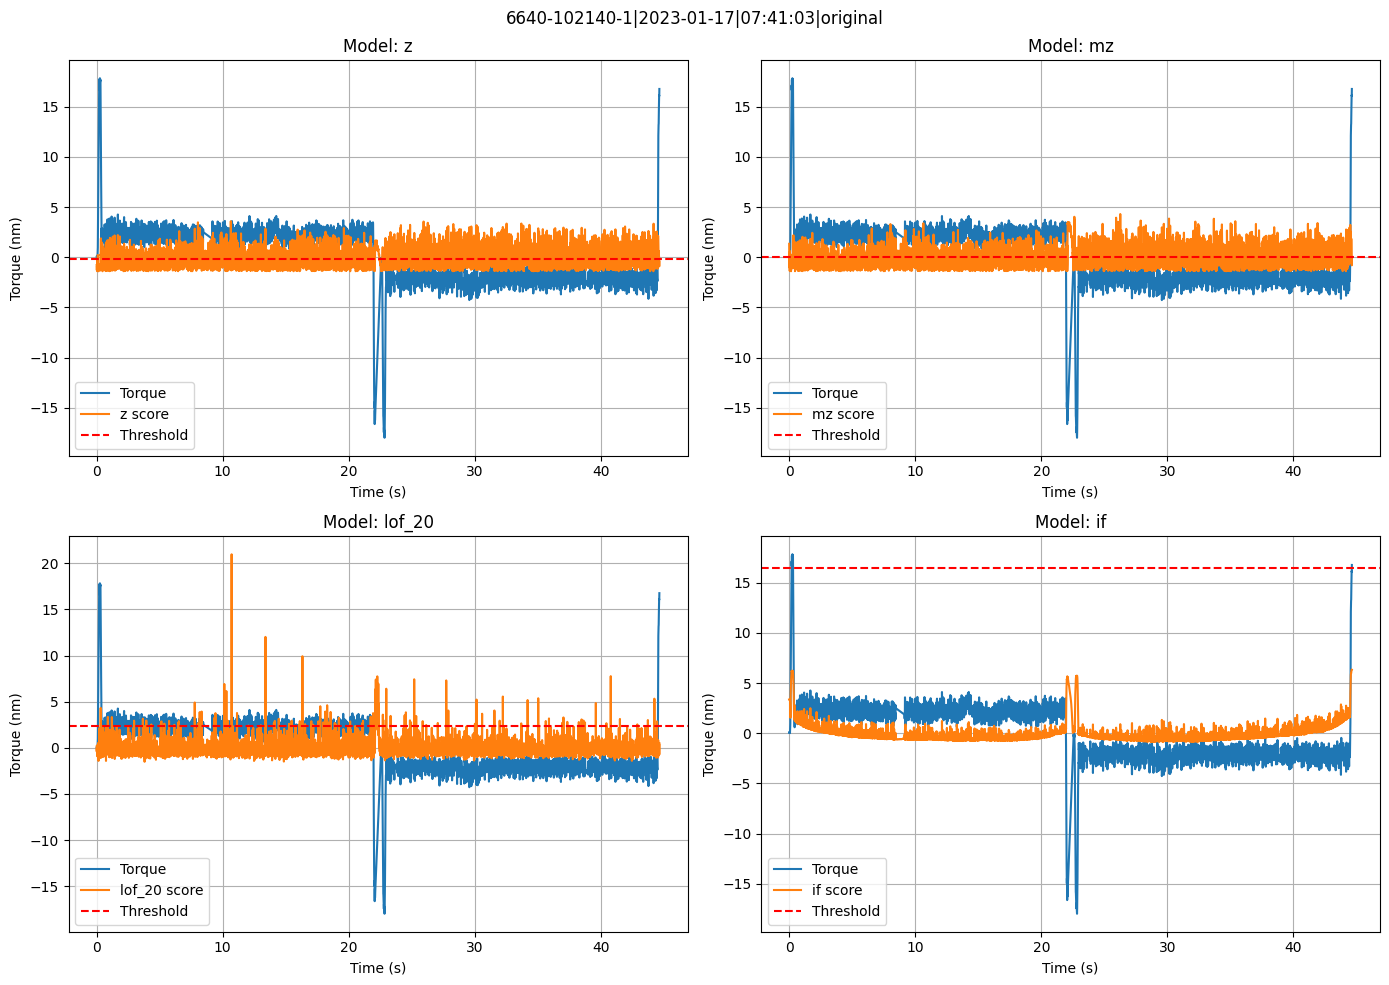

[(0, <function <lambda> at 0x0000016080C85F80>), (1, <function <lambda> at 0x0000016080C84540>), (2, <function <lambda> at 0x0000016080C84CC0>), (3, <function <lambda> at 0x0000016080C86020>)]
z


C:\Users\P70080564\AppData\Local\Temp\ipykernel_9028\3591073581.py:31: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
c:\Users\P70080564\python\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\P70080564\AppData\Local\Temp\ipykernel_9028\3591073581.py:31: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


mz


c:\Users\P70080564\python\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


lof_20


c:\Users\P70080564\python\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


if


c:\Users\P70080564\python\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


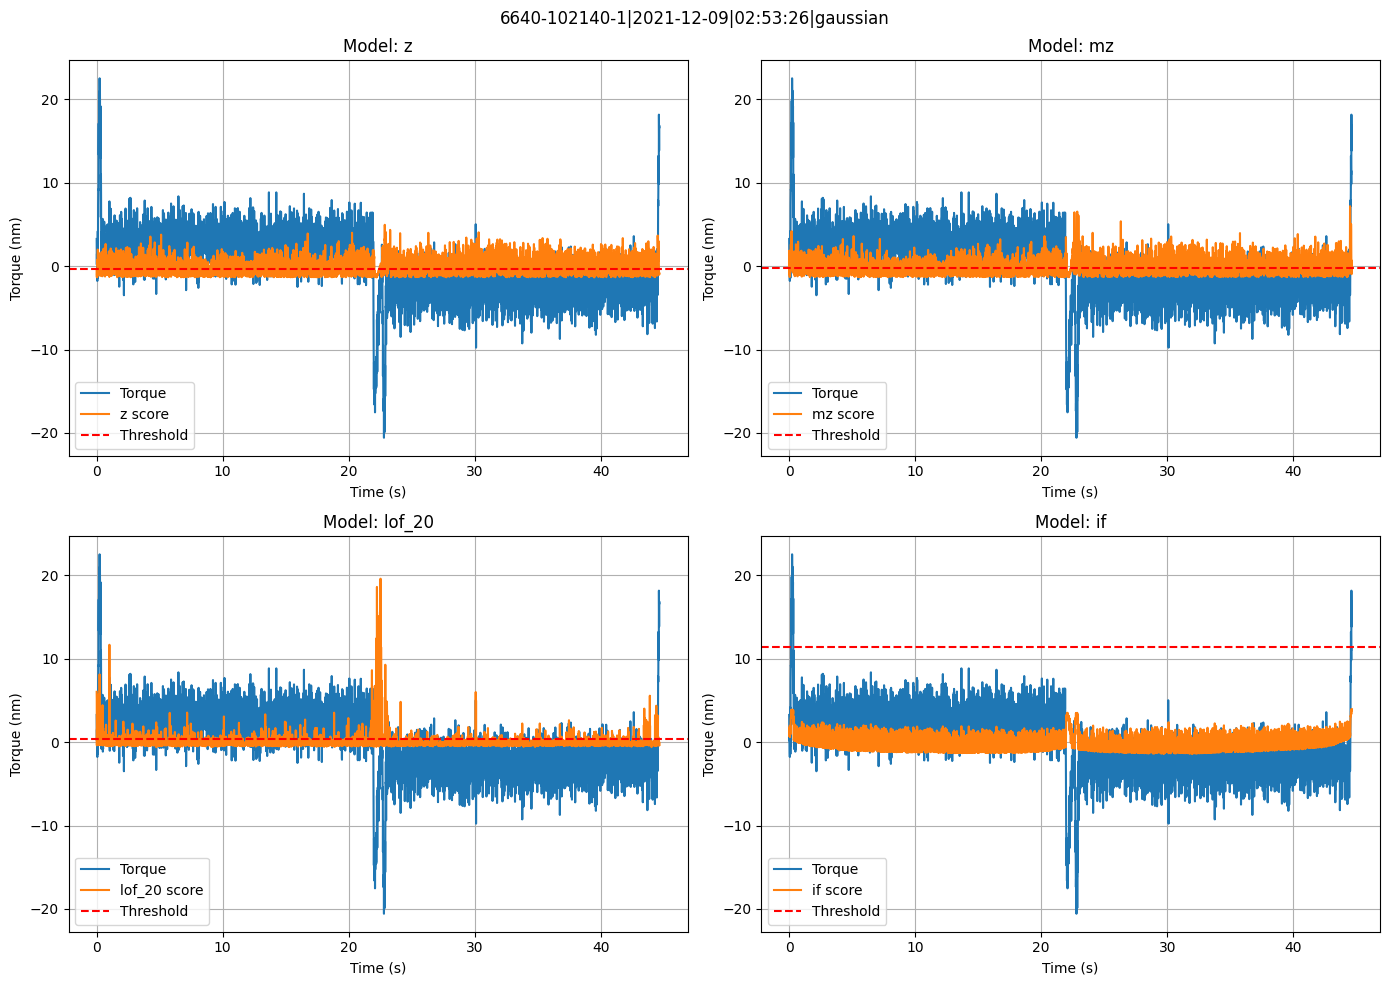

In [23]:
def plot_multiple(plots, title="", colnums=3, colsize=5, rowsize=5):
    # Calculate the number of rows needed
    cols = colnums
    num_plots = len(plots)
    rows = (num_plots + cols - 1) // cols  # Ceiling division to ensure enough rows

    # Create a figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=(colsize*cols, rowsize*rows))

    # Flatten axes for easy indexing if needed
    axes = axes.flatten()

    print([x for x in enumerate(plots)])
    # Loop through the DataFrames and plot each in the corresponding subplot
    for i, fn in enumerate(plots):
        fn(axes[i])

    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(title)
    plt.tight_layout()

    # Show the plot
    plt.show()

def _plot_experiments(exp, methodname, ax, id=None):
    ## Calculate the best threshold (by F1 score) for the model
    precision, recall, thresholds = exp.results['pr'][methodname]
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold_index = np.nanargmax(f1_scores)
    best_threshold = thresholds[best_threshold_index]

    ##

    print(methodname)
    df = exp.results['df'].sort_values(by='timeindex')
    df = df[df['seqid'] == id]

    ax.plot(df['timeindex'], df['torqueactual'], label="Torque")

    (ymin, _) = ax.get_ylim()
    scaler = StandardScaler()
    X = scaler.fit_transform(abs(df[[methodname]]))

    
    # # Highlight parts in df[[name]] that are over the best_threshold
    # print(best_threshold, len(df))
    # over_threshold = df[df[methodname] > best_threshold]
    # print(len(over_threshold))
    # ax.scatter(over_threshold['timeindex'], scaler.transform(over_threshold[[methodname]]), color='red', label='Over Threshold', s=2)

    ax.plot(df['timeindex'], X, label=f'{methodname} score')
    #ax.axhline(y=scaler.transform(([[best_threshold]])[0][0]), color='red', linestyle='--', label='Threshold')

    ax.axhline(y=scaler.transform([[best_threshold]])[0][0], color='red', linestyle='--', label='Threshold')

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Torque (nm)')
    #ax.title = f'ID : {id} - Model: {model}'
    ax.set_title(f'Model: {methodname}')
    ax.legend()
    ax.grid(True)

modelnames = ['z', 'mz', 'lof_20', 'if']
seqid_org = np.random.choice([seqid for seqid in exp.results['df']['seqid'].unique() if 'original' in seqid])
seqid_gauss = np.random.choice([seqid for seqid in exp.results['df']['seqid'].unique() if 'gaussian' in seqid])
print([lambda ax: name for name in modelnames])
plot_multiple([lambda ax, name=name: _plot_experiments(exp, name, ax, seqid_org) for name in modelnames], title=f"{seqid_org}", colnums=2, colsize=7)
plot_multiple([lambda ax, name=name: _plot_experiments(exp, name, ax, seqid_gauss) for name in modelnames], title=f"{seqid_gauss}", colnums=2, colsize=7)
#plot_experiments(exp, 'z', np.random.choice(exp.results['df']['seqid'].unique()))

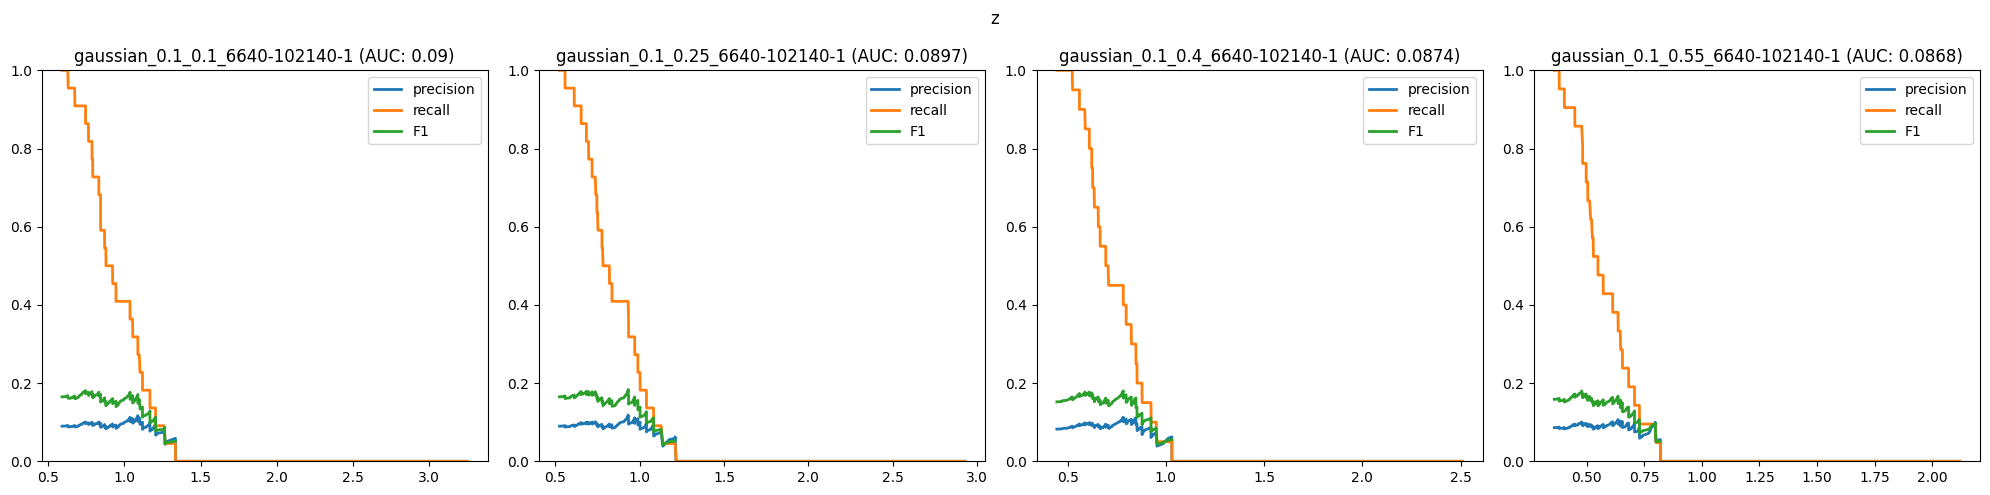

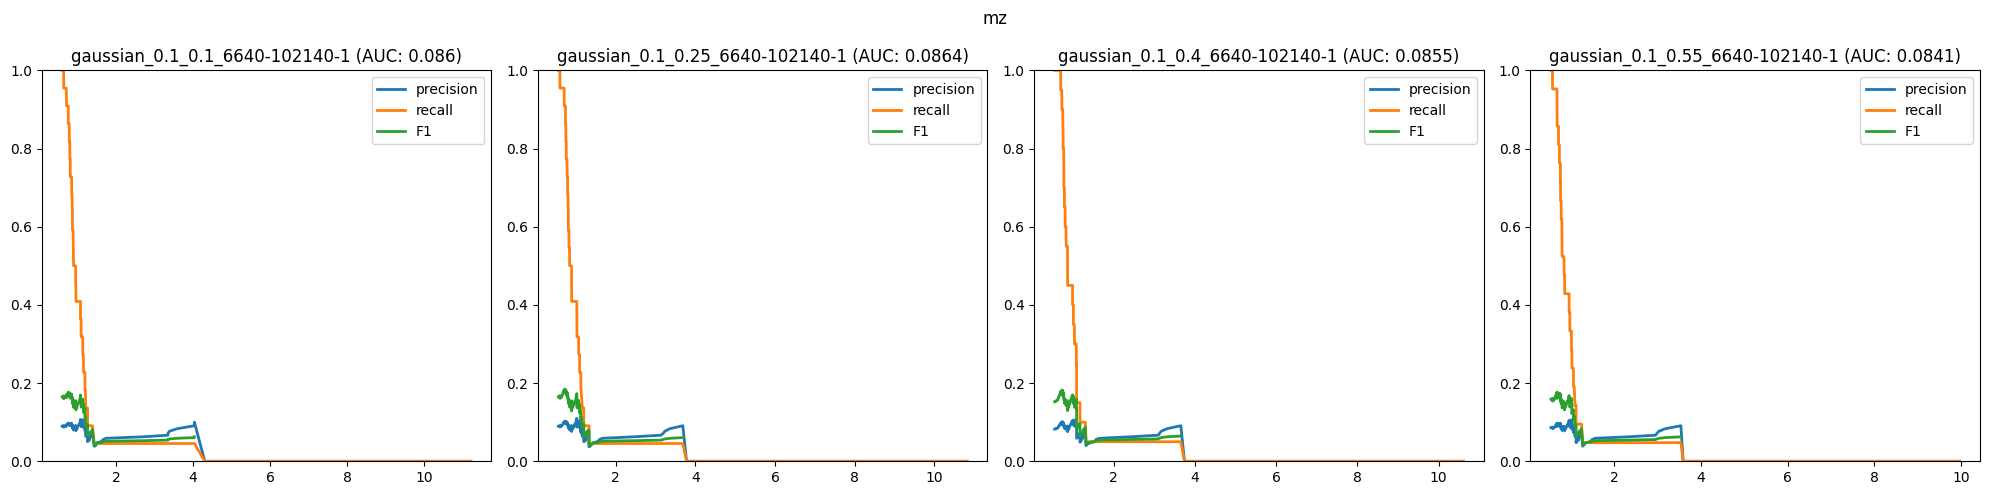

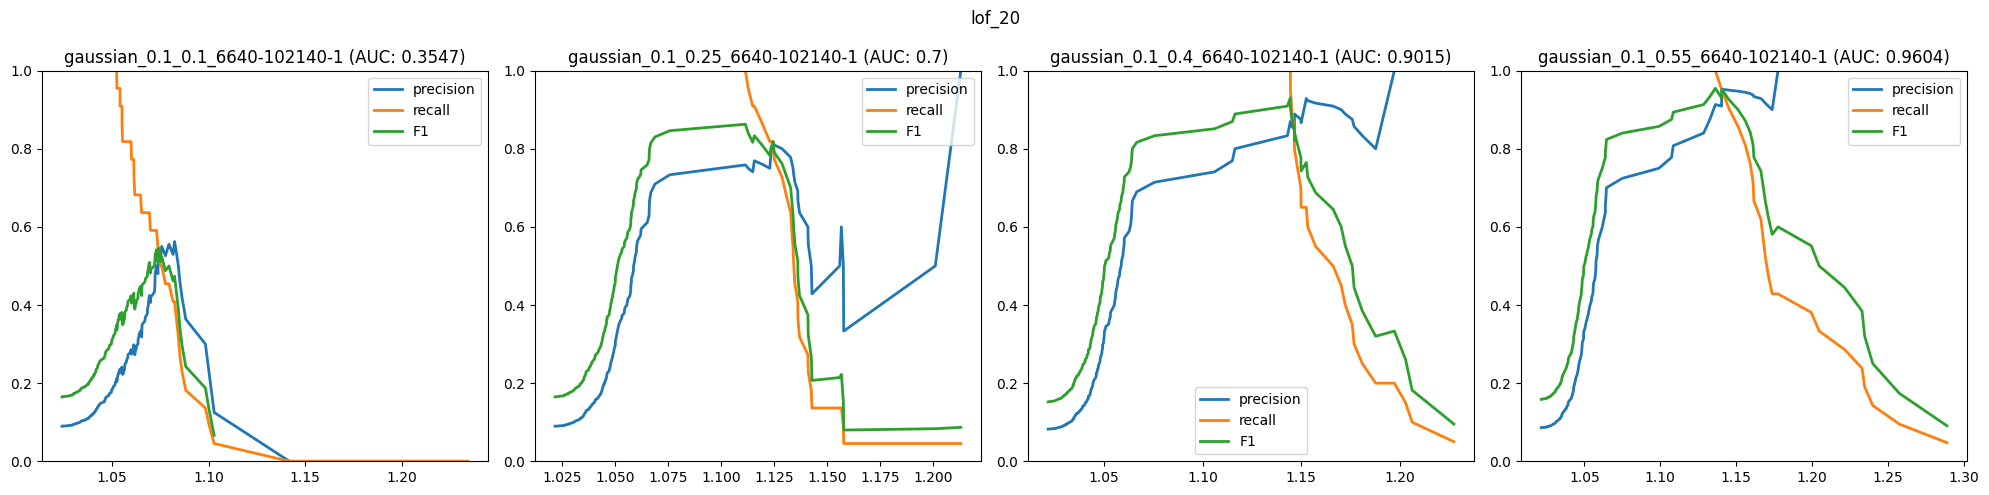

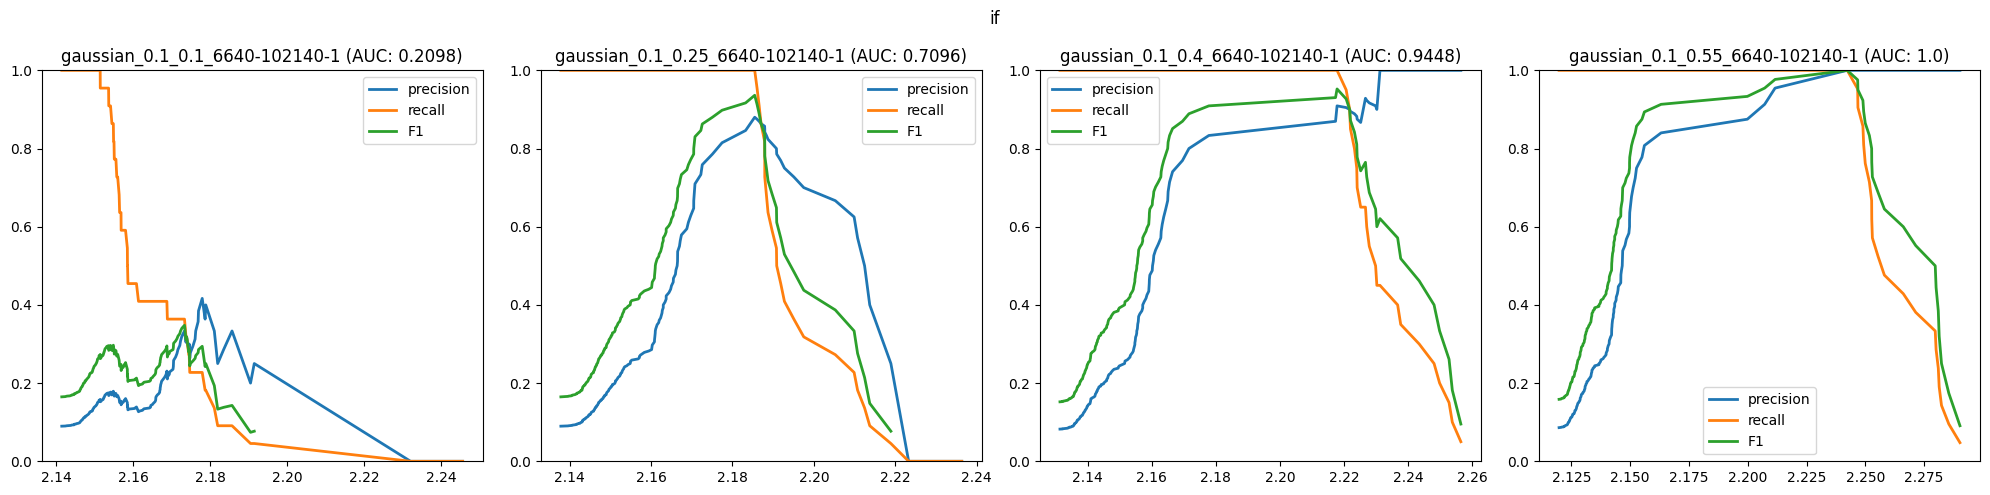

In [9]:
rp_curves = {}
for exp in models:
    mname = exp.name
    rp_curves[mname] = {}
    for (ename, exp) in exps_gaussian.items():
        rp_curves[mname][ename] = exp.results['pr'][mname]
    with warnings.catch_warnings(action="ignore"):
        plot_rpcurves(rp_curves[mname], colnums=4, title=mname, auc=True, f1=True)
        

In [ ]:
rp_curves = {}
for exp in models:
    mname = exp.name
    for (ename, exp) in exps_gaussian.items():
        print(f"{mname}_{ename}")
        rp_curves[f"{mname}_{ename}"] = exp.results['pr'][mname]


with warnings.catch_warnings(action="ignore"):
    plot_rpcurves(rp_curves, colnums=4, title=mname, auc=True, f1=False, showtitle=False, linewidth=3)

# SINUSOIDAL

In [ ]:
# Load or Run Experiments, depending on load_experiments
exps_sinusoidal = load_or_run_experiments(load_experiments, sinusoidal_params, name_sinusoidal_experiment, run_sinusoidal_experiment, df_in, models, exp_columns, syn_column, synratio, ids)



In [ ]:
rp_curves = {}
for exp in models:
    mname = exp.name
    rp_curves[mname] = {}
    for (ename, exp) in exps_sinusoidal.items():
        rp_curves[mname][ename] = exp.results['pr'][mname]
    with warnings.catch_warnings(action="ignore"):
        plot_rpcurves(rp_curves[mname], colnums=4, title=mname, auc=True, f1=False)
        

In [ ]:
rp_curves = {}
for exp in models:
    mname = exp.name
    for (ename, exp) in exps_sinusoidal.items():
        print(f"{mname}_{ename}")
        rp_curves[f"{mname}_{ename}"] = exp.results['pr'][mname]


with warnings.catch_warnings(action="ignore"):
    plot_rpcurves(rp_curves, colnums=4, title=mname, auc=True, f1=False, showtitle=False, linewidth=3)

# POINT

In [ ]:
# Load or Run Experiments, depending on load_experiments
exps_point = load_or_run_experiments(load_experiments, point_params, name_point_experiment, run_point_experiment, df_in, models, exp_columns, syn_column, synratio, ids)

In [ ]:
rp_curves = {}
for exp in models:
    mname = exp.name
    rp_curves[mname] = {}
    for (ename, exp) in exps_point.items():
        rp_curves[mname][ename] = exp.results['pr'][mname]
    with warnings.catch_warnings(action="ignore"):
        plot_rpcurves(rp_curves[mname], colnums=4, title=mname, auc=True, f1=False)
        

In [ ]:
rp_curves = {}
for exp in models:
    mname = exp.name
    for (ename, exp) in exps_point.items():
        print(f"{mname}_{ename}")
        rp_curves[f"{mname}_{ename}"] = exp.results['pr'][mname]


with warnings.catch_warnings(action="ignore"):
    plot_rpcurves(rp_curves, colnums=4, title=mname, auc=True, f1=False, showtitle=False)

In [ ]:
# for intensity in [0.025, 0.05, 0.075, 0.1, 0.125, 0.15]:
#     print(f"Running Experiment gaussian {intensity}")
#     run_gaussian_experiment(df_in, models, ['torqueactual'], 0.1, intensity)
# for intensity in [0.25, 0.5, 0.75, 1, 1.25, 1.5]:
#     print(f"Running Experiment point {intensity}")
#     run_point_experiment(df_in, models, ['torqueactual'], 0.1, intensity)
#     print(f"Running Experiment sinusoidal {intensity}")
#     run_sinusoidal_experiment(df_in, models, ['torqueactual'], 0.1, intensity)

In [ ]:
folder_path = g.experiments_folder_path

files_to_unpickle = [
    file for file in os.listdir(folder_path)
    if os.path.isfile(os.path.join(folder_path, file)) and file.endswith("6640-102140-1")
]

files_to_unpickle


In [ ]:
unpickled_data = {}
for file_name in files_to_unpickle:
    unpickled_data[file_name] = Experiment.unpickle(file_name)    
    
for (name, exp) in unpickled_data.items():
    print(f"{name} - {exp.results['auc-pr']}")